# Query Performance Comparison Across Datasets

This notebook compares query performance between different methods across all available datasets. It focuses on:
- Comparing query execution times between standard and cached queries
- Analyzing performance by dataset and operation type
- Visualizing performance differences with clear and concise plots
- Aggregating results across multiple runs for more robust comparisons

In [20]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re  # Add this import for regular expressions
from pathlib import Path
import scipy.stats as stats
import warnings
import matplotlib.ticker as ticker
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')

# Set publication-ready plotting style
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'Times New Roman', 'Palatino', 'DejaVu Serif'],
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 10,
    'figure.figsize': [10, 6],
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.05,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.axisbelow': True,
    'axes.labelpad': 10
})

# Define output folders
outFolder = "output_no_allocation"
groundTruthFolder = "output_no_allocation"

plt.rcParams['text.usetex'] = False  # Set to True only if you have LaTeX installed
plt.rcParams['mathtext.default'] = 'regular'

# Define the methods to compare
METHODS = [
    {
        "name": "M4-NoC",
        "path": f"../{groundTruthFolder}/timeQueries/",
        "method": "m4",
        "database": "influx"
    },
    {
        "name": "M4$^\\infty$-C",
        "path": f"../{outFolder}/timeCacheQueries/",
        "method": "m4Inf",
        "database": "influx"
    },
    # {
    #     "name": "MinMaxCache",
    #     "path": f"../{outFolder}/timeMinMaxCacheQueries/",
    #     "method": "minmax",
    #     "database": "influx"
    # },
]

# Create a folder for saving publication-ready figures
FIGURES_DIR = "../figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

# Generate a publication-ready color palette
# Using ColorBrewer-inspired palette for better distinction in papers
METHOD_COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Define a consistent style function for publication-ready plots
def set_publication_style(ax, title=None, xlabel=None, ylabel=None, legend_title=None):
    """Apply consistent publication-ready styling to matplotlib axis"""
    if title:
        ax.set_title(title, fontweight='bold', pad=15)
    if xlabel:
        ax.set_xlabel(xlabel, fontweight='bold')
    if ylabel:
        ax.set_ylabel(ylabel, fontweight='bold')
    
    # Apply grid style
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_axisbelow(True)
    
    # Style spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
    
    # Format legend if it exists
    if ax.get_legend():
        if legend_title:
            ax.legend(title=legend_title, frameon=True, facecolor='white', 
                     framealpha=0.9, edgecolor='black')
        else:
            ax.legend(frameon=True, facecolor='white', framealpha=0.9, edgecolor='black')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return ax

## Load Query Results Data

Load experiment results from all available datasets, aggregating across runs.

In [5]:
def load_results(base_path, method, database_type, table_name):
    """
    Load results from multiple experiment runs into a single dataframe
    
    Parameters:
    -----------
    base_path : str
        Base path to the queries directory
    method : str    
        Name of the method used (e.g., m4Inf, m4)
    database_type : str
        Type of database (influx, postgres, etc.)
    table_name : str
        Name of the database table
        
    Returns:
    --------
    pd.DataFrame or None: Combined results from all runs
    """
    path_pattern = os.path.join(base_path, method, database_type, table_name, "run_*", "results.csv")
    csv_files = glob.glob(path_pattern)
    
    if not csv_files:
        return None
    
    dfs = []
    for csv_file in csv_files:
        run_name = os.path.basename(os.path.dirname(csv_file))
        df = pd.read_csv(csv_file)
        df['run'] = run_name
        df['dataset'] = table_name
        dfs.append(df)
    
    combined_df = pd.concat(dfs, ignore_index=True)
    
    # Convert date columns to datetime if they exist
    date_columns = ['from', 'to']
    for col in date_columns:
        if col in combined_df.columns:
            combined_df[col] = pd.to_datetime(combined_df[col])
            
    # Add duration column
    if 'from' in combined_df.columns and 'to' in combined_df.columns:
        combined_df['duration_sec'] = (combined_df['to'] - combined_df['from']).dt.total_seconds()
    
    return combined_df

# Function to aggregate results from multiple runs
def aggregate_runs(df):
    """
    Aggregate results from multiple runs by grouping by query characteristics
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing results from multiple runs
        
    Returns:
    --------
    pd.DataFrame: Aggregated results with statistics across runs
    """
    if df is None or len(df) == 0:
        return None
    
    # Group by query characteristics (not by run)
    groupby_cols = ['dataset', 'query #', 'query_type', 'group_by', 'aggregation', 'time_interval']
    group_cols = [col for col in groupby_cols if col in df.columns]
    
    # Aggregate the Time (sec) column across runs
    agg_df = df.groupby(group_cols).agg({
        'Time (sec)': ['mean', 'median', 'std', 'min', 'max', 'count'],
        'run': 'nunique'  # Count number of runs
    }).reset_index()
    
    # Flatten the multi-level column names
    agg_df.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] for col in agg_df.columns]
    
    # Rename some columns for clarity
    agg_df = agg_df.rename(columns={
        'Time (sec)_mean': 'Time (sec)', 
        'Time (sec)_count': 'query_count',
        'run_nunique': 'run_count'
    })
    
    return agg_df

# Operation type mapping for better readability
def get_operation_type_mapping():
    return {
        'P': 'Pan',
        'ZI': 'Zoom In',
        'ZO': 'Zoom Out',
        'R': 'Resize',
        'MC': 'Measure Change',
        'PD': 'Pattern Detection',
        'NaN': 'Initial Query'
    }

## Find All Available Datasets and Load Data

In [6]:
# First, find all available datasets by looking at directories
def find_datasets(method_info):
    base_path = method_info["path"]
    method = method_info["method"]
    database = method_info["database"]
    
    # Find all dataset directories
    dataset_pattern = os.path.join(base_path, method, database, "*")
    datasets = []
    
    for dataset_dir in glob.glob(dataset_pattern):
        if os.path.isdir(dataset_dir):
            dataset_name = os.path.basename(dataset_dir)
            datasets.append(dataset_name)
    
    return datasets

# Get unique datasets from all methods
all_datasets = set()
for method in METHODS:
    datasets = find_datasets(method)
    all_datasets.update(datasets)

all_datasets = sorted(list(all_datasets))
print(f"Found {len(all_datasets)} datasets: {all_datasets}")

# Load data for each method and dataset
raw_results_by_dataset = {}  # Store raw results
results_by_dataset = {}      # Store aggregated results
all_results = []             # Store all aggregated results

for dataset in all_datasets:
    print(f"\nLoading data for dataset: {dataset}")
    dataset_results = []
    dataset_raw_results = []
    
    for i, method in enumerate(METHODS):
        print(f"  Loading {method['name']}...")
        
        df = load_results(
            base_path=method['path'],
            method=method['method'],
            database_type=method['database'],
            table_name=dataset
        )
        
        if df is not None and not df.empty:
            # Add method name and color index
            df['method'] = method['name']
            df['method_idx'] = i
            
            # Add readable operation type
            op_type_map = get_operation_type_mapping()
            df['operation'] = df.apply(
                lambda row: 'Initial Query' if pd.isna(row['query_type']) else op_type_map.get(row['query_type'], row['query_type']), 
                axis=1
            )
            
            # Store raw results first
            dataset_raw_results.append(df)
            
            # Aggregate results across runs
            agg_df = aggregate_runs(df)
            if agg_df is not None:
                # Add method name and operation type to aggregated data
                agg_df['method'] = method['name']
                agg_df['method_idx'] = i
                agg_df['operation'] = agg_df.apply(
                    lambda row: 'Initial Query' if pd.isna(row['query_type']) else op_type_map.get(row['query_type'], row['query_type']), 
                    axis=1
                )
                
                dataset_results.append(agg_df)
                all_results.append(agg_df)
                print(f"    Loaded {len(df)} queries from {agg_df['run_count'].iloc[0]} runs, aggregated to {len(agg_df)} unique queries")
            else:
                print(f"    Error aggregating results")
        else:
            print(f"    No data found")
    
    if dataset_raw_results:
        raw_results_by_dataset[dataset] = pd.concat(dataset_raw_results, ignore_index=True)
    
    if dataset_results:
        results_by_dataset[dataset] = pd.concat(dataset_results, ignore_index=True)

# Combine all results into a single dataframe for overall analysis
if all_results:
    all_combined = pd.concat(all_results, ignore_index=True)
    print(f"\nLoaded a total of {len(all_combined)} aggregated queries across {len(all_datasets)} datasets")
    
    # Print run count information
    for dataset in results_by_dataset:
        for method in METHODS:
            method_name = method['name']
            method_data = results_by_dataset[dataset][results_by_dataset[dataset]['method'] == method_name]
            if not method_data.empty:
                run_count = method_data['run_count'].iloc[0]
                print(f"Dataset: {dataset}, Method: {method_name}, Runs: {run_count}")
else:
    all_combined = None
    print("\nNo data was loaded.")

Found 2 datasets: ['intel_lab_exp', 'soccer_exp']

Loading data for dataset: intel_lab_exp
  Loading M4-NoC...
    Loaded 255 queries from 5 runs, aggregated to 50 unique queries
  Loading M4$^\infty$-C...
    Loaded 255 queries from 5 runs, aggregated to 50 unique queries

Loading data for dataset: soccer_exp
  Loading M4-NoC...
    Loaded 255 queries from 5 runs, aggregated to 50 unique queries
  Loading M4$^\infty$-C...
    Loaded 255 queries from 5 runs, aggregated to 50 unique queries

Loaded a total of 200 aggregated queries across 2 datasets
Dataset: intel_lab_exp, Method: M4-NoC, Runs: 5
Dataset: intel_lab_exp, Method: M4$^\infty$-C, Runs: 5
Dataset: soccer_exp, Method: M4-NoC, Runs: 5
Dataset: soccer_exp, Method: M4$^\infty$-C, Runs: 5


## Performance Comparison by Dataset

Let's compare the performance across all datasets using the aggregated results.

Summary of Query Times by Dataset and Method:


,dataset,method,mean_time,median_time,avg_query_count,run_count
0,intel_lab_exp,M4$^\infty$-C,0.229685,0.225638,5.0,5.0
1,intel_lab_exp,M4-NoC,1.712594,1.688781,5.0,5.0
2,soccer_exp,M4$^\infty$-C,0.859028,0.834523,5.0,5.0
3,soccer_exp,M4-NoC,2.429063,2.421329,5.0,5.0



Performance Improvement Summary:


,Dataset,Baseline,Compared Method,Baseline Avg (sec),Method Avg (sec),Improvement %,Status
0,intel_lab_exp,M4-NoC,M4$^\infty$-C,1.712594,0.229685,86.588464,Faster
1,soccer_exp,M4-NoC,M4$^\infty$-C,2.429063,0.859028,64.635408,Faster


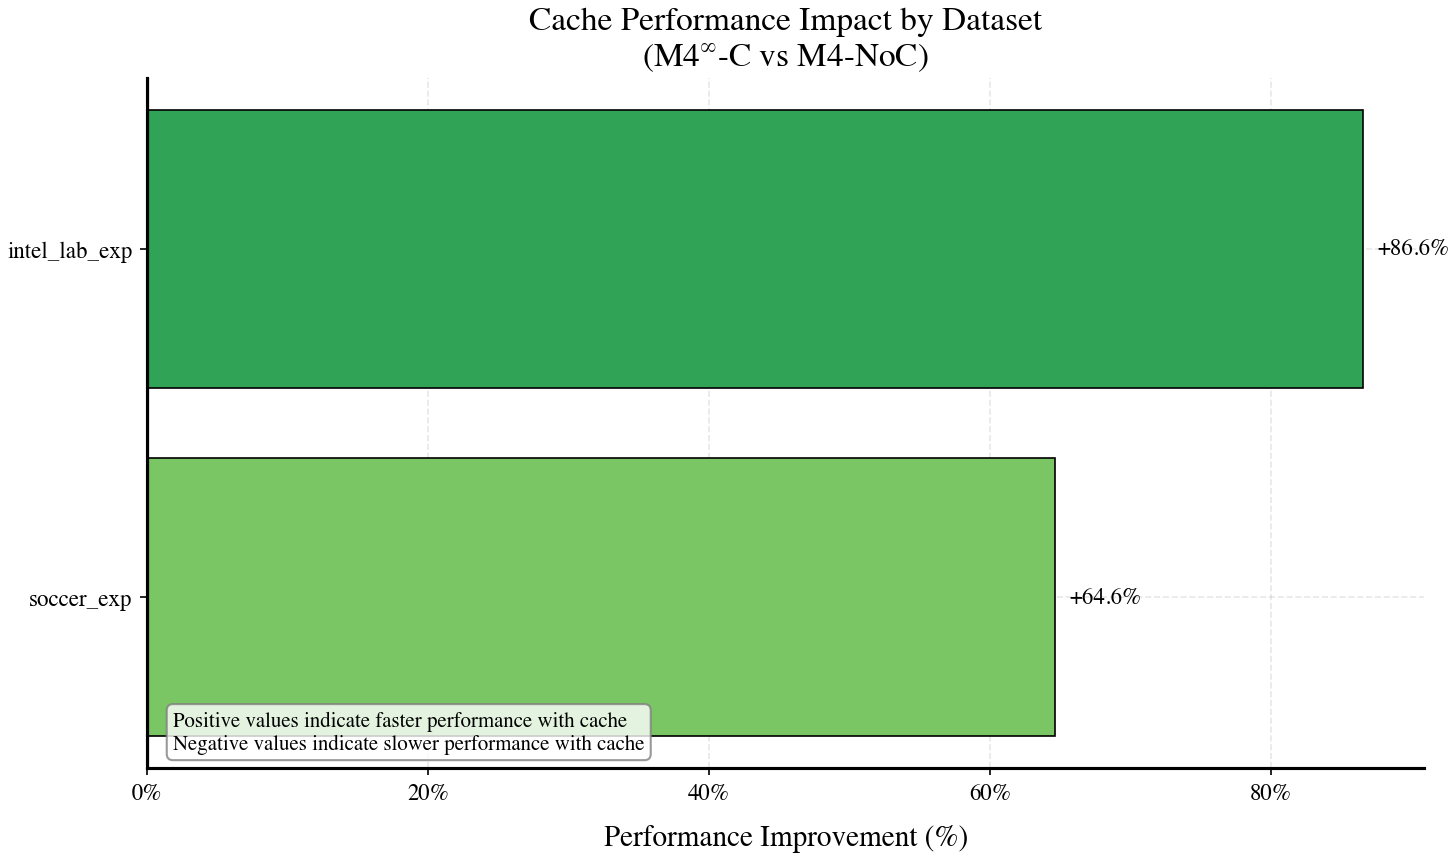

In [7]:
if all_combined is not None:
    # Create a summary table of performance by dataset and method
    dataset_summary = all_combined.groupby(['dataset', 'method'])[['Time (sec)', 'Time (sec)_median', 'query_count', 'run_count']].agg([
        'mean'
    ]).reset_index()
    
    # Flatten the column multi-index
    dataset_summary.columns = ['_'.join(col).strip('_') for col in dataset_summary.columns.values]
    
    # Rename columns for clarity
    dataset_summary = dataset_summary.rename(columns={
        'dataset_': 'dataset',
        'method_': 'method',
        'Time (sec)_mean': 'mean_time',
        'Time (sec)_median_mean': 'median_time',
        'query_count_mean': 'avg_query_count',
        'run_count_mean': 'run_count'
    })
    
    # Display summary table
    print("Summary of Query Times by Dataset and Method:")
    pd.set_option('display.max_rows', None)
    display(dataset_summary)
    
    # Calculate improvement percentages
    improvement_data = []
    
    for dataset in all_datasets:
        dataset_data = dataset_summary[dataset_summary['dataset'] == dataset]
        
        if len(dataset_data) >= 2:  # Need at least two methods for comparison
            methods = dataset_data['method'].unique()
            if len(methods) >= 2:
                baseline_method = METHODS[0]['name']
                baseline_avg = dataset_data[dataset_data['method'] == baseline_method]['mean_time'].values[0]
                
                for method in methods:
                    if method != baseline_method:
                        method_avg = dataset_data[dataset_data['method'] == method]['mean_time'].values[0]
                        imp_pct = ((baseline_avg - method_avg) / baseline_avg) * 100
                        
                        improvement_data.append({
                            'Dataset': dataset,
                            'Baseline': baseline_method,
                            'Compared Method': method,
                            'Baseline Avg (sec)': baseline_avg,
                            'Method Avg (sec)': method_avg,
                            'Improvement %': imp_pct,
                            'Status': 'Faster' if imp_pct > 0 else 'Slower'
                        })
    
    # Display improvement percentages
    if improvement_data:
        improvements_df = pd.DataFrame(improvement_data)
        print("\nPerformance Improvement Summary:")
        display(improvements_df.sort_values('Improvement %', ascending=False))
        
        # Sort datasets by improvement percentage for better visualization
        improvements_df = improvements_df.sort_values('Improvement %')
        
        # Create publication-ready improvement chart
        fig, ax = plt.subplots(figsize=(10, max(6, len(all_datasets) * 0.7)))
        
        # Create horizontal bars with custom colors
        bars = ax.barh(
            improvements_df['Dataset'], 
            improvements_df['Improvement %'],
            color=[plt.cm.RdYlGn(0.7 * (x + 100) / 150) if x > 0 else plt.cm.RdYlGn(0.3 * (x + 100) / 100) for x in improvements_df['Improvement %']],
            edgecolor='black',
            linewidth=0.8
        )
        
        # Add percentage labels with proper formatting
        for bar in bars:
            width = bar.get_width()
            label_x_pos = width + 1 if width > 0 else width - 1
            ha = 'left' if width > 0 else 'right'
            value = f"+{width:.1f}%" if width > 0 else f"{width:.1f}%"
            fontweight = 'bold' if abs(width) > 20 else 'normal'
            
            ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                   value, va='center', ha=ha, fontsize=11, fontweight=fontweight)
        
        # Draw vertical line at x=0
        ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
        
        # Set axis labels and title
        ax.set_xlabel('Performance Improvement (%)')
        ax.set_title(f'Cache Performance Impact by Dataset\n({METHODS[1]["name"]} vs {METHODS[0]["name"]})')
        
        # Add explanatory text
        ax.text(0.02, 0.02, 
                "Positive values indicate faster performance with cache\nNegative values indicate slower performance with cache",
                transform=ax.transAxes, fontsize=10, va='bottom', 
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        # Format x-axis with percentage symbol
        ax.xaxis.set_major_formatter(ticker.PercentFormatter())
        
        # Apply publication styling
        set_publication_style(ax)
        
        plt.tight_layout()
        
        # Save figure
        plt.savefig(os.path.join(FIGURES_DIR, "improvement_by_dataset.pdf"))
        plt.savefig(os.path.join(FIGURES_DIR, "improvement_by_dataset.png"))
        plt.show()
else:
    print("No data available for comparison.")

## Performance Comparison by Operation Type

Let's break down the performance by operation type for each dataset using the aggregated results.

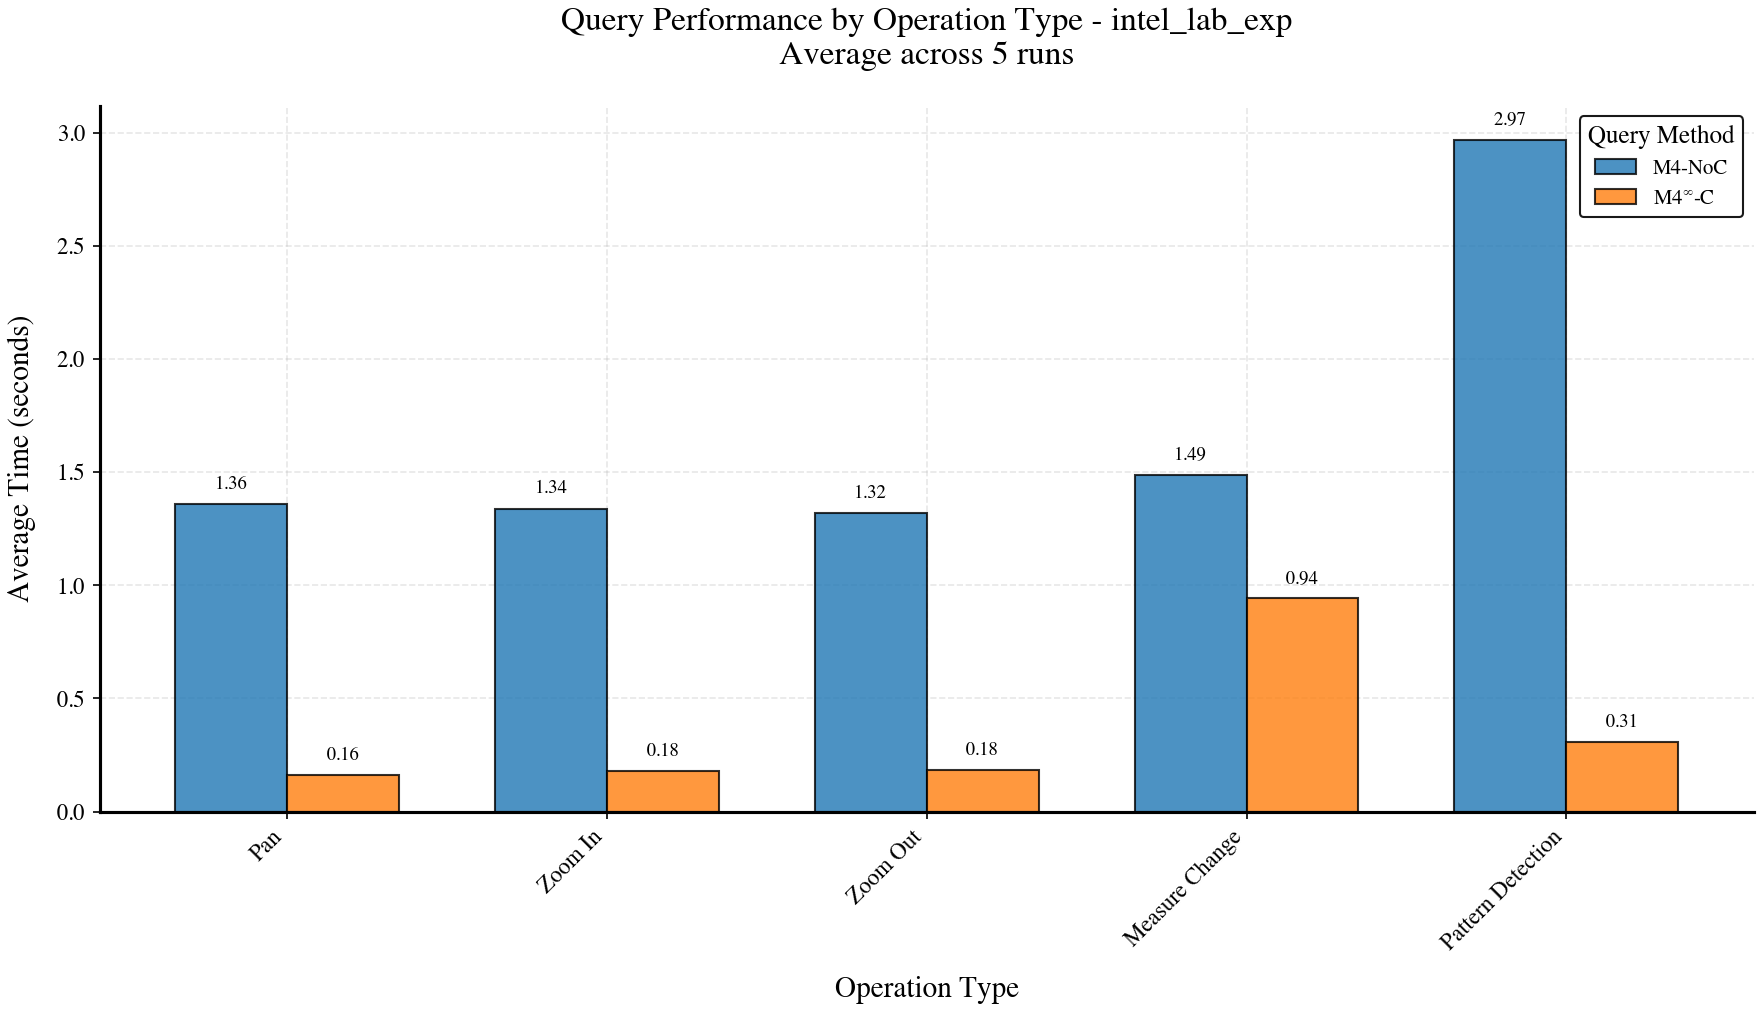

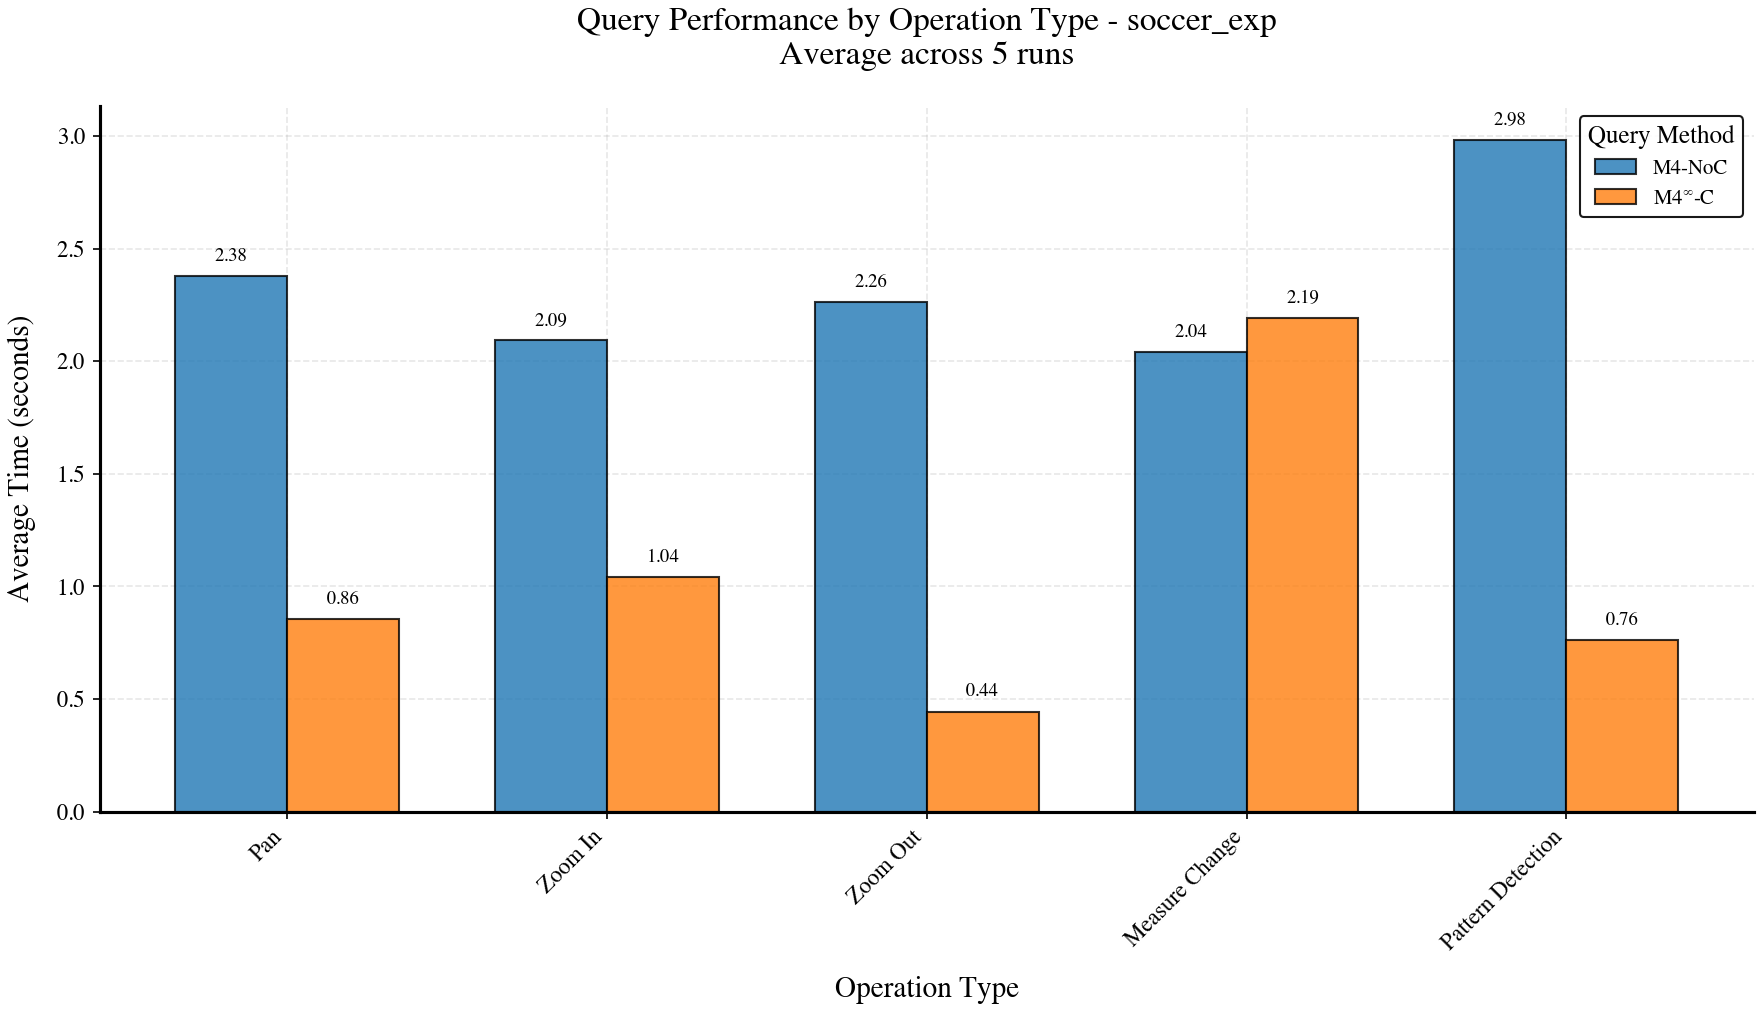



### Performance Breakdown for Dataset: intel_lab_exp (Averaged across 5 runs)


Time (sec)           Time (sec)_std            \
method            M4$^\infty$-C    M4-NoC  M4$^\infty$-C    M4-NoC   
operation                                                            
Measure Change         0.943462  1.487443       0.146329  0.102206   
Pan                    0.161995  1.358525       0.030055  0.116991   
Pattern Detection      0.308231  2.969687       0.025462  0.217610   
Zoom In                0.178963  1.338695       0.034262  0.089418   
Zoom Out               0.183638  1.319099       0.012709  0.091326   

                    query_count         
method            M4$^\infty$-C M4-NoC  
operation                               
Measure Change                5      5  
Pan                           5      5  
Pattern Detection             5      5  
Zoom In                       5      5  
Zoom Out                      5      5


Operation Improvements (M4-NoC vs M4$^\infty$-C):


,operation,mean_baseline,mean_comparison,improvement_pct,count_baseline,count_comparison
2,Pattern Detection,2.969687,0.308231,89.620750,11,11
1,Pan,1.358525,0.161995,88.075642,25,25
3,Zoom In,1.338695,0.178963,86.631515,10,10
4,Zoom Out,1.319099,0.183638,86.078528,2,2
0,Measure Change,1.487443,0.943462,36.571577,2,2


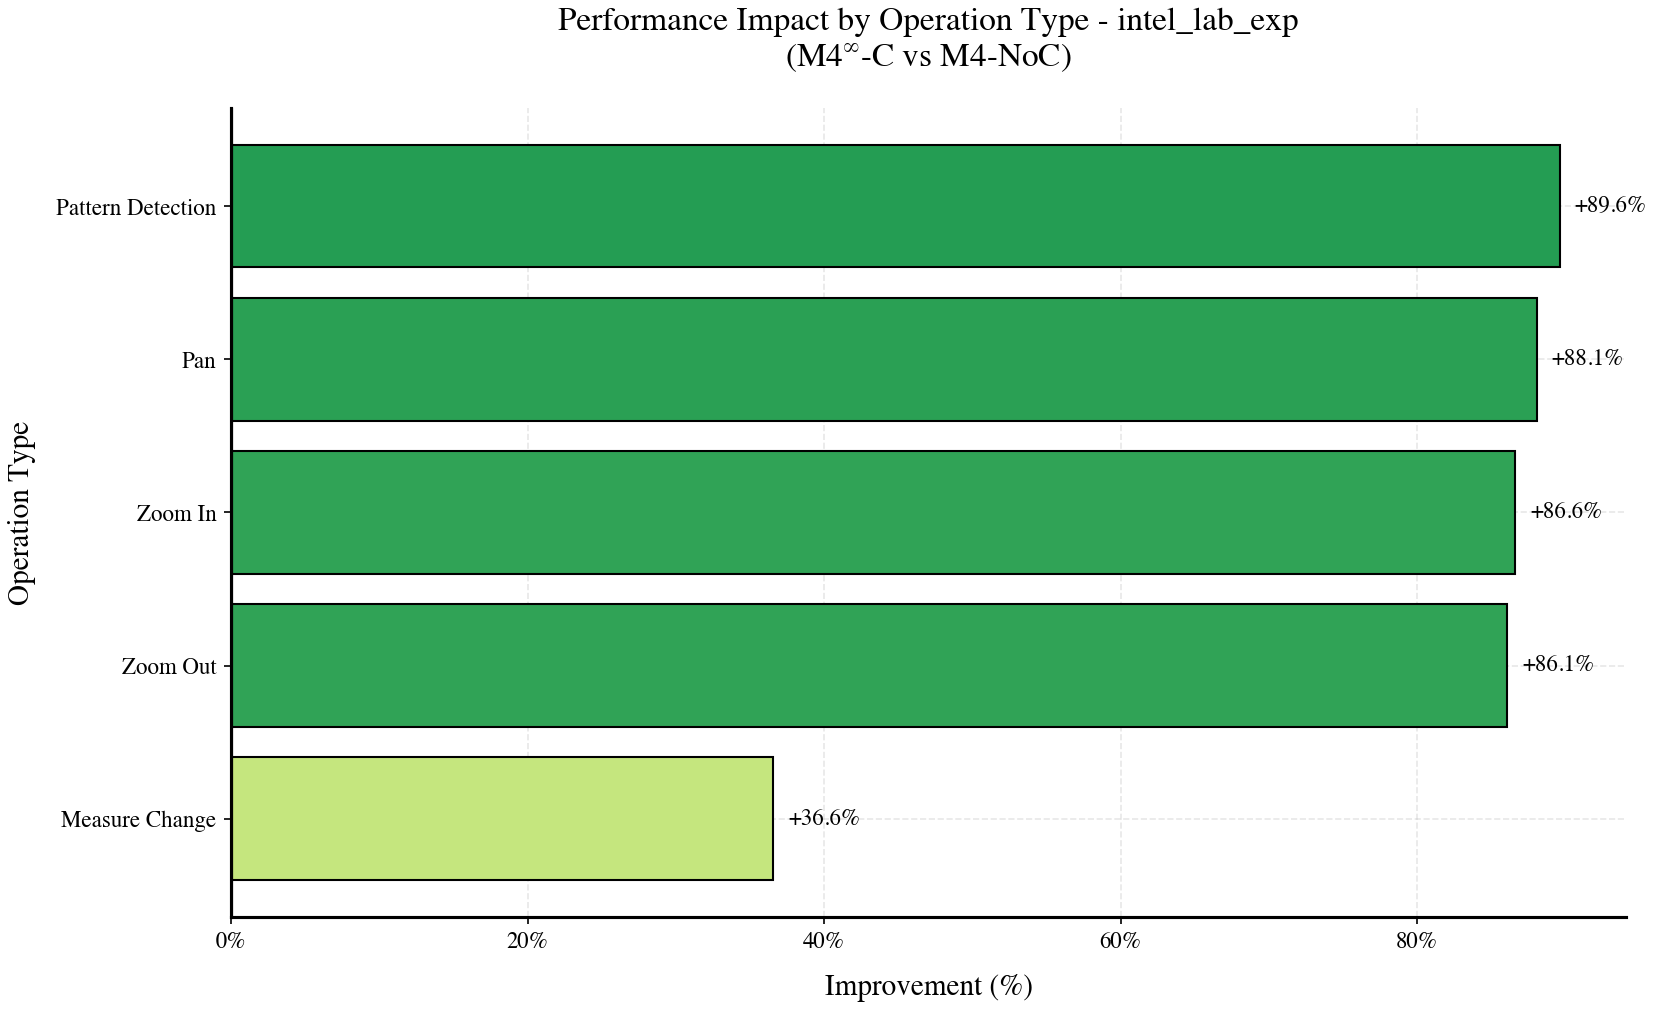



### Performance Breakdown for Dataset: soccer_exp (Averaged across 5 runs)


Time (sec)           Time (sec)_std            \
method            M4$^\infty$-C    M4-NoC  M4$^\infty$-C    M4-NoC   
operation                                                            
Measure Change         2.191680  2.040277       0.092415  0.041410   
Pan                    0.856094  2.378729       0.075465  0.087170   
Pattern Detection      0.761587  2.984534       0.055505  0.101033   
Zoom In                1.041808  2.092840       0.121228  0.118535   
Zoom Out               0.444583  2.262402       0.010163  0.089696   

                    query_count         
method            M4$^\infty$-C M4-NoC  
operation                               
Measure Change                5      5  
Pan                           5      5  
Pattern Detection             5      5  
Zoom In                       5      5  
Zoom Out                      5      5


Operation Improvements (M4-NoC vs M4$^\infty$-C):


,operation,mean_baseline,mean_comparison,improvement_pct,count_baseline,count_comparison
4,Zoom Out,2.262402,0.444583,80.349071,6,6
2,Pattern Detection,2.984534,0.761587,74.482208,12,12
1,Pan,2.378729,0.856094,64.010467,18,18
3,Zoom In,2.092840,1.041808,50.220382,13,13
0,Measure Change,2.040277,2.191680,-7.420729,1,1


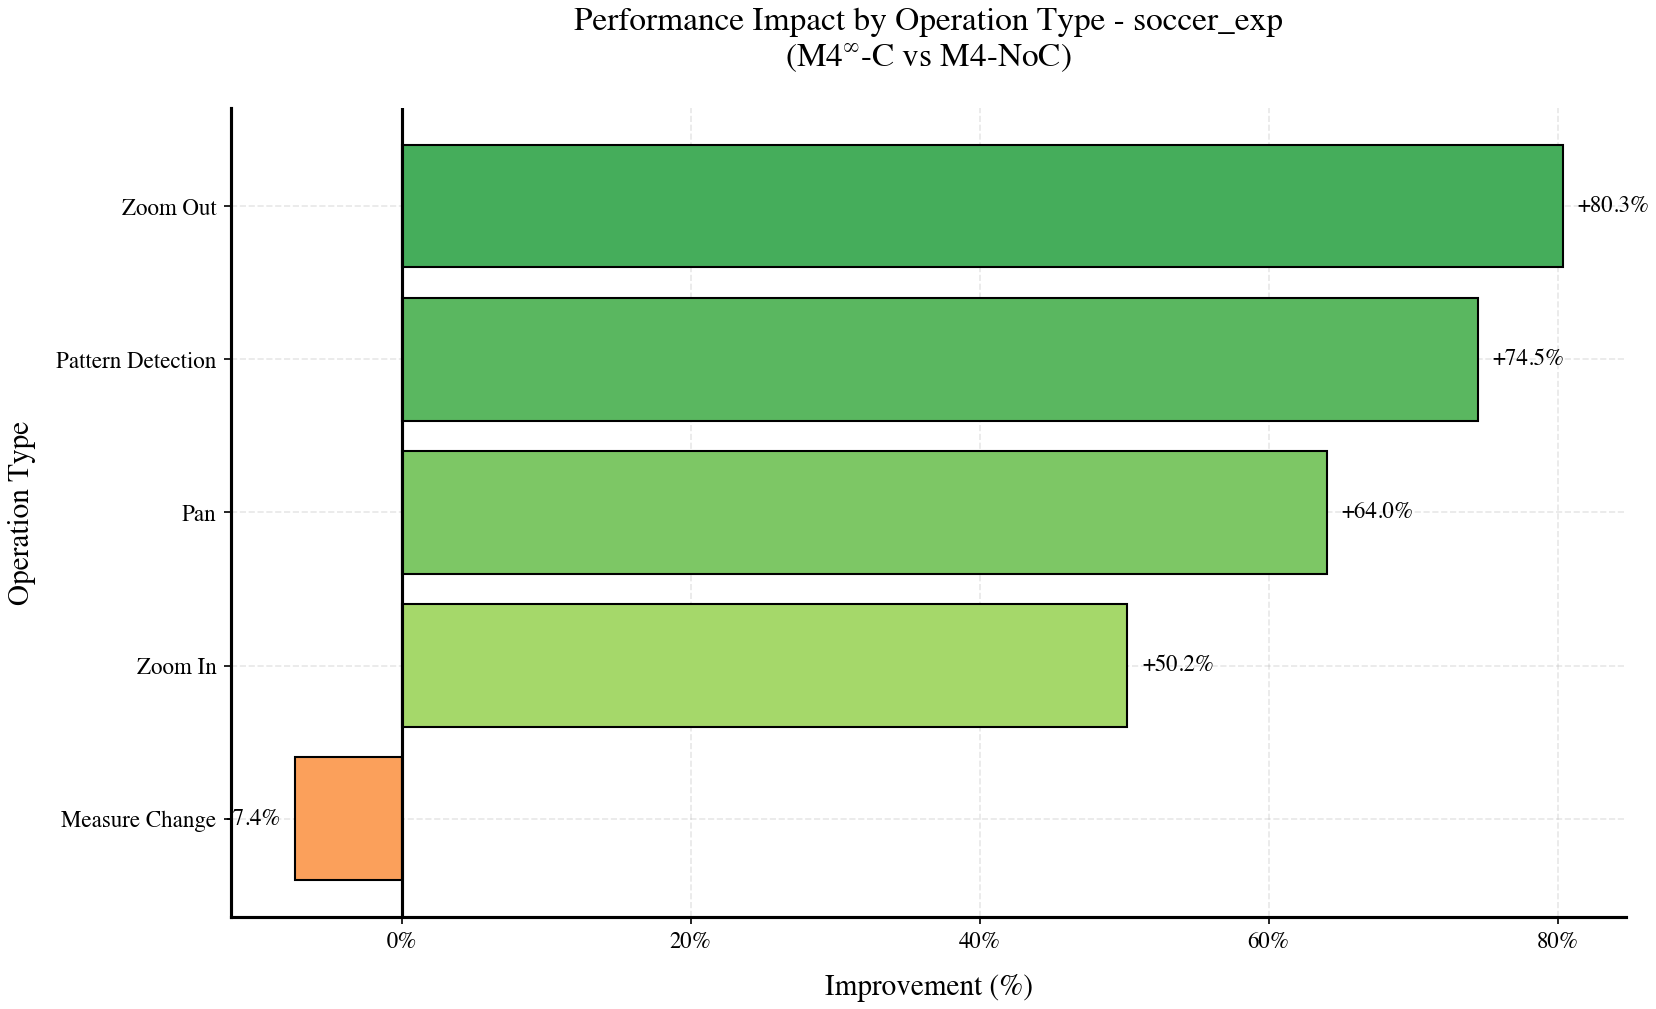

In [8]:
if all_combined is not None:
    # Get unique operations across all datasets
    all_ops = sorted(all_combined['operation'].unique())
    
    # Create a figure with subplots - one per dataset
    n_datasets = len(all_datasets)
    
    # Create publication-ready figures for each dataset separately
    for i, dataset in enumerate(all_datasets):
        if dataset in results_by_dataset:
            dataset_df = results_by_dataset[dataset]
            method_names = dataset_df['method'].unique()
            run_count = dataset_df['run_count'].iloc[0]
            
            # Group data by operation type and method
            op_perf = dataset_df.groupby(['operation', 'method'])['Time (sec)'].mean().reset_index()
            
            # Get operations for this dataset and sort them in a meaningful order
            operations = op_perf['operation'].unique()
            op_order = ['Initial Query', 'Pan', 'Zoom In', 'Zoom Out', 'Resize', 'Measure Change', 'Pattern Detection']
            operations = sorted(operations, key=lambda x: op_order.index(x) if x in op_order else 999)
            
            # Create the figure
            fig, ax = plt.subplots(figsize=(12, 7))
            
            # Set bar properties
            bar_width = 0.35
            opacity = 0.8
            bar_positions = np.arange(len(operations))
            method_colors = METHOD_COLORS[:len(method_names)]
            
            for j, method in enumerate(method_names):
                method_data = op_perf[op_perf['method'] == method]
                # Create a lookup dict by operation
                method_by_op = {row['operation']: row['Time (sec)'] for _, row in method_data.iterrows()}
                
                # Extract values in the correct order
                values = [method_by_op.get(op, 0) for op in operations]
                
                # Plot bars
                offset = (j - len(method_names)/2 + 0.5) * bar_width
                bars = ax.bar(
                    bar_positions + offset, 
                    values, 
                    bar_width,
                    color=method_colors[j], 
                    label=method,
                    edgecolor='black',
                    linewidth=1,
                    alpha=opacity
                )
                
                # Add value labels on top of bars
                for k, bar in enumerate(bars):
                    height = bar.get_height()
                    ax.text(
                        bar.get_x() + bar.get_width()/2,
                        height + 0.05,
                        f'{height:.2f}',
                        ha='center', 
                        va='bottom',
                        fontsize=9,
                        rotation=0
                    )
            
            # Set the x-axis labels
            ax.set_xticks(bar_positions)
            ax.set_xticklabels(operations, rotation=45, ha='right')
            
            # Set labels and title
            title = f'Query Performance by Operation Type - {dataset}'
            subtitle = f'Average across {run_count} runs'
            ax.set_title(f'{title}\n{subtitle}', pad=20)
            ax.set_xlabel('Operation Type')
            ax.set_ylabel('Average Time (seconds)')
            
            # Create a custom legend with method names and color patches
            ax.legend(title='Query Method')
            
            # Apply publication styling
            set_publication_style(ax, legend_title='Query Method')
            
            # Adjust layout
            plt.tight_layout()
            
            # Save figure
            filename_safe = dataset.replace(' ', '_').lower()
            plt.savefig(os.path.join(FIGURES_DIR, f"operations_{filename_safe}.pdf"))
            plt.savefig(os.path.join(FIGURES_DIR, f"operations_{filename_safe}.png"))
            plt.show()
    
    # Create detailed operation comparison tables for each dataset
    for dataset in all_datasets:
        if dataset in results_by_dataset:
            print(f"\n\n### Performance Breakdown for Dataset: {dataset} (Averaged across {results_by_dataset[dataset]['run_count'].iloc[0]} runs)")
            
            dataset_df = results_by_dataset[dataset]
            
            # Detailed operation type comparison including standard deviations
            op_stats = dataset_df.pivot_table(
                index='operation',
                columns='method',
                values=['Time (sec)', 'Time (sec)_std', 'query_count']
            )
            
            display(op_stats)
            
            # Calculate improvements for this dataset by operation
            if len(dataset_df['method'].unique()) >= 2:
                baseline_method = METHODS[0]['name']
                comparison_method = METHODS[1]['name']
                
                # Get data for comparison
                baseline_data = dataset_df[dataset_df['method'] == baseline_method]
                comparison_data = dataset_df[dataset_df['method'] == comparison_method]
                
                # Group by operation and calculate stats
                ops_baseline = baseline_data.groupby('operation')['Time (sec)'].agg(['mean', 'count']).reset_index()
                ops_comparison = comparison_data.groupby('operation')['Time (sec)'].agg(['mean', 'count']).reset_index()
                
                # Merge the data
                ops_merged = pd.merge(ops_baseline, ops_comparison, on='operation', suffixes=('_baseline', '_comparison'))
                
                # Calculate improvement percentage
                ops_merged['improvement_pct'] = ((ops_merged['mean_baseline'] - ops_merged['mean_comparison']) / 
                                              ops_merged['mean_baseline']) * 100
                
                # Sort by improvement percentage
                ops_merged = ops_merged.sort_values('improvement_pct', ascending=False)
                
                # Display the results
                print(f"\nOperation Improvements ({baseline_method} vs {comparison_method}):")
                display(ops_merged[['operation', 'mean_baseline', 'mean_comparison', 
                                  'improvement_pct', 'count_baseline', 'count_comparison']])
                
                # Create publication-ready chart for operation improvements
                fig, ax = plt.subplots(figsize=(12, 7))
                
                # Sort operations by improvement percentage
                sorted_ops = ops_merged.sort_values('improvement_pct', ascending=True)
                
                # Create horizontal bars with custom colors
                bars = ax.barh(
                    sorted_ops['operation'], 
                    sorted_ops['improvement_pct'], 
                    color=[plt.cm.RdYlGn(0.7 * (x + 100) / 150) if x > 0 else plt.cm.RdYlGn(0.3 * (x + 100) / 100) for x in sorted_ops['improvement_pct']],
                    edgecolor='black',
                    linewidth=1
                )
                
                # Add value labels
                for bar in bars:
                    width = bar.get_width()
                    label_x_pos = width + 1 if width > 0 else width - 1
                    ha = 'left' if width > 0 else 'right'
                    value = f"+{width:.1f}%" if width > 0 else f"{width:.1f}%"
                    
                    ax.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
                           value, va='center', ha=ha, fontsize=11)
                
                # Add vertical line at x=0
                ax.axvline(x=0, color='black', linestyle='-', linewidth=1.5)
                
                # Format axes
                ax.set_title(f'Performance Impact by Operation Type - {dataset}\n({comparison_method} vs {baseline_method})', pad=20)
                ax.set_xlabel('Improvement (%)')
                ax.set_ylabel('Operation Type')
                ax.xaxis.set_major_formatter(ticker.PercentFormatter())
                
                # Apply publication styling
                set_publication_style(ax)
                
                # Save figure
                filename_safe = dataset.replace(' ', '_').lower()
                plt.savefig(os.path.join(FIGURES_DIR, f"operation_improvements_{filename_safe}.pdf"))
                plt.savefig(os.path.join(FIGURES_DIR, f"operation_improvements_{filename_safe}.png"))
                plt.show()
else:
    print("No data available for comparison.")

## Query Execution Time Evolution

Let's visualize how query times evolve across the sequence of operations, highlighting pattern detection queries.

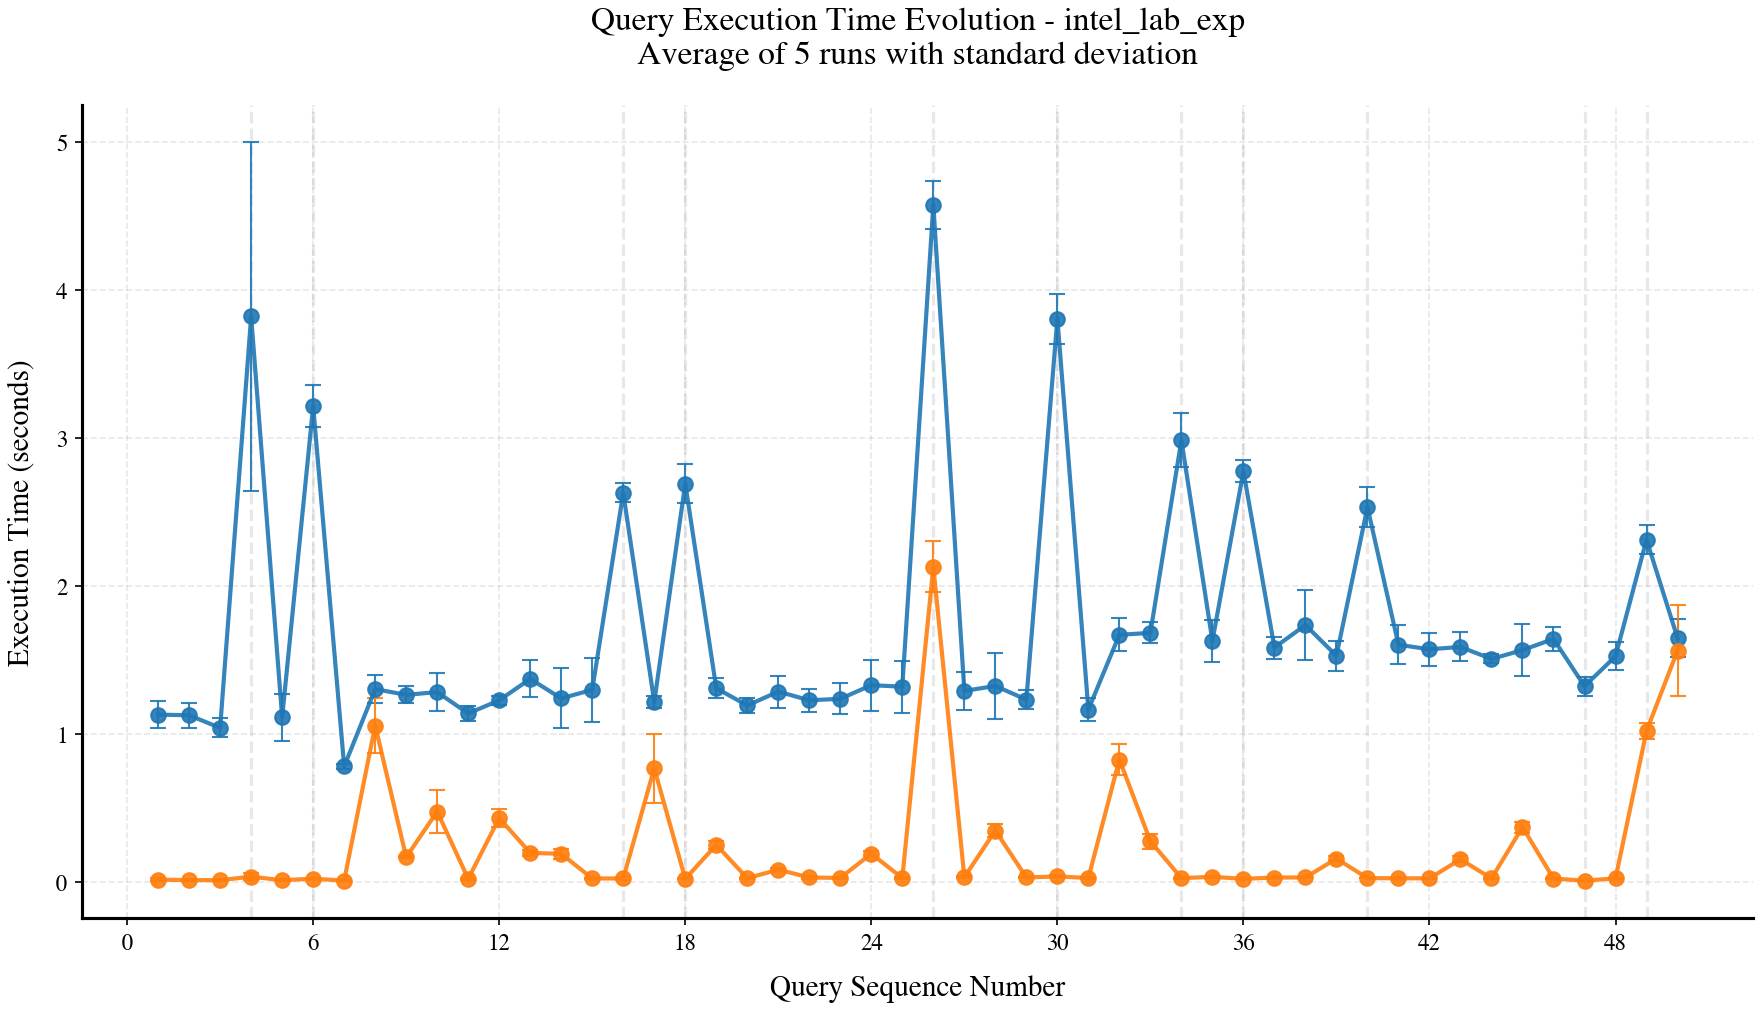

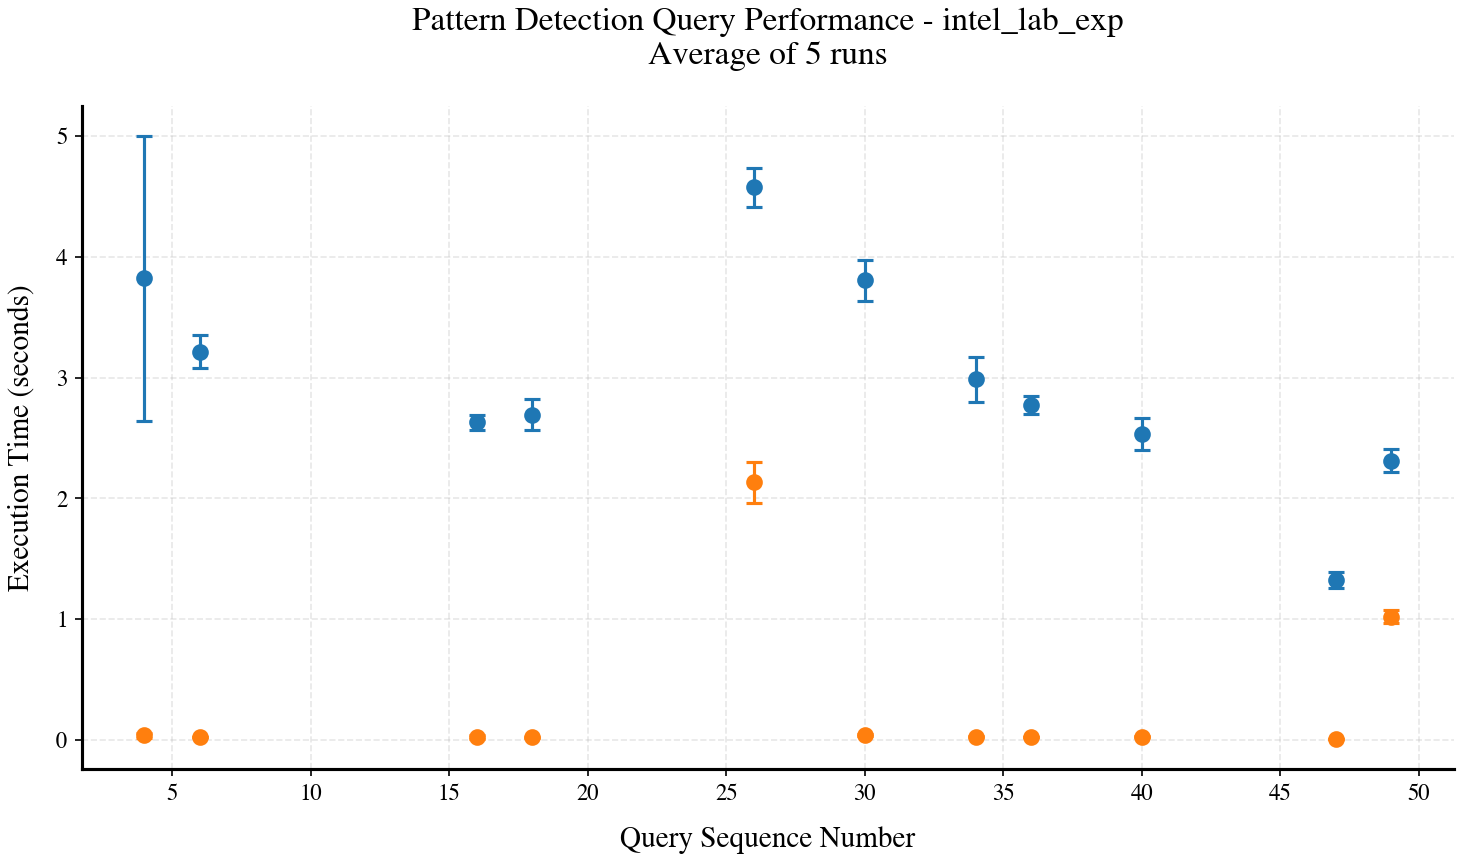

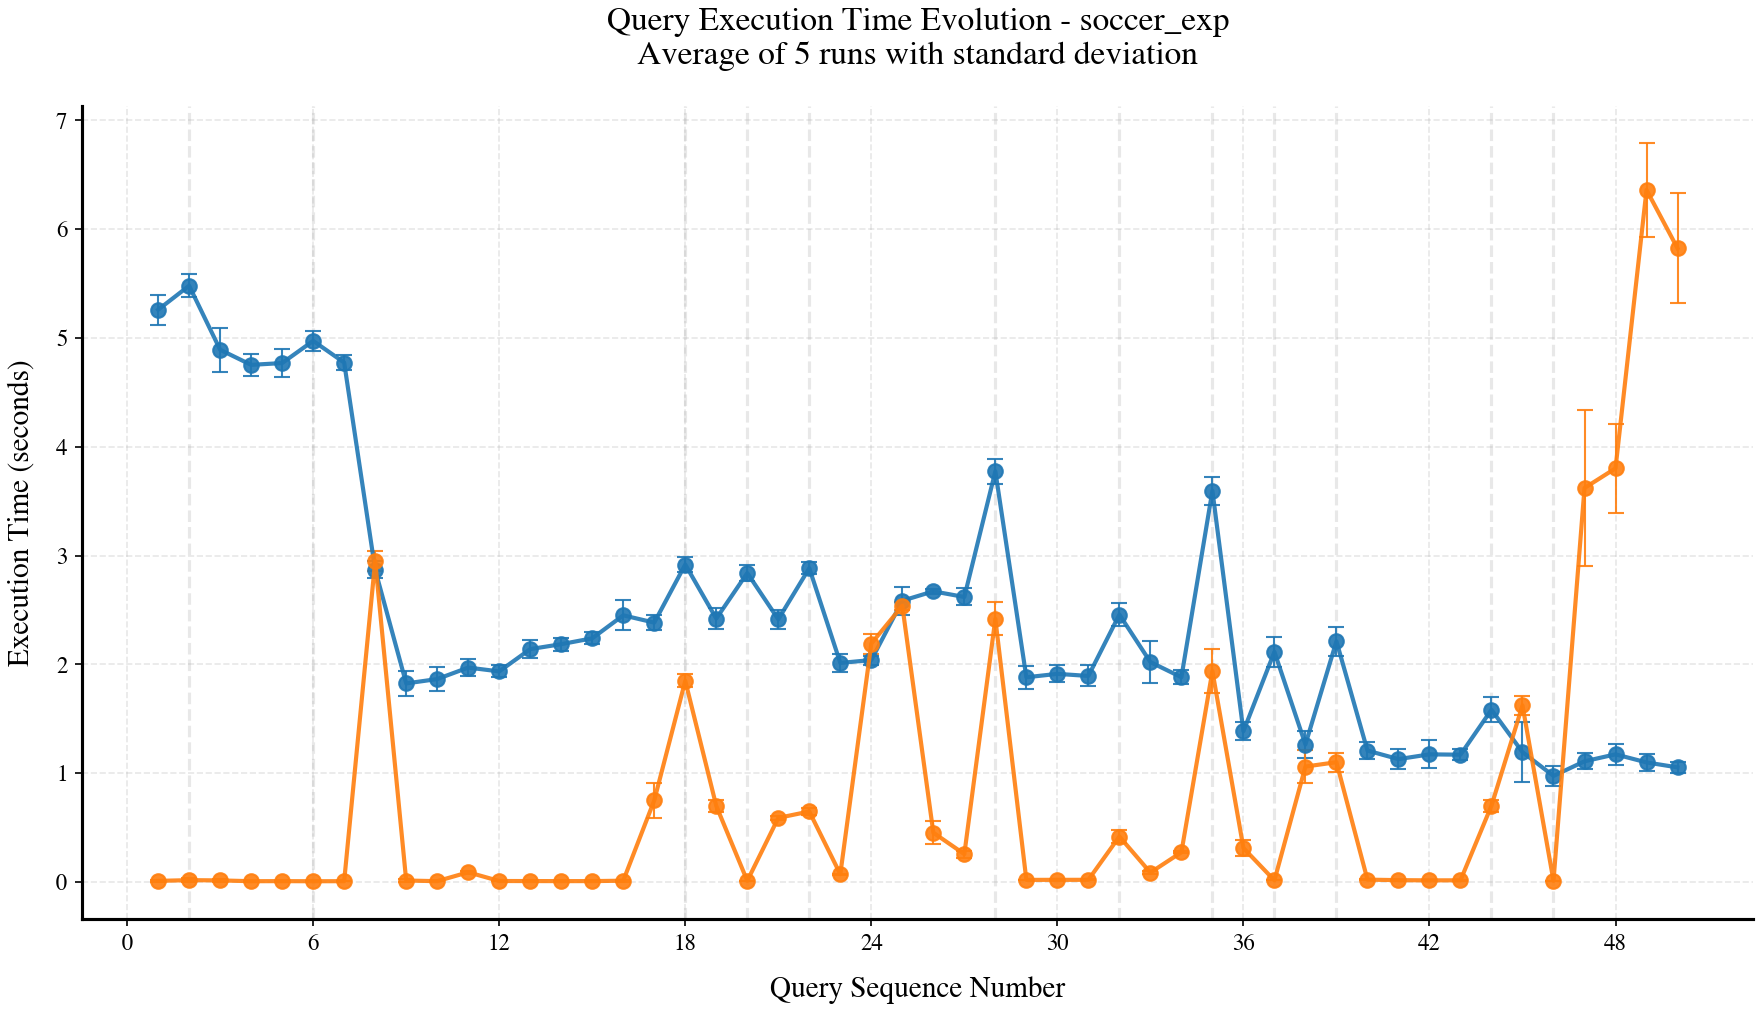

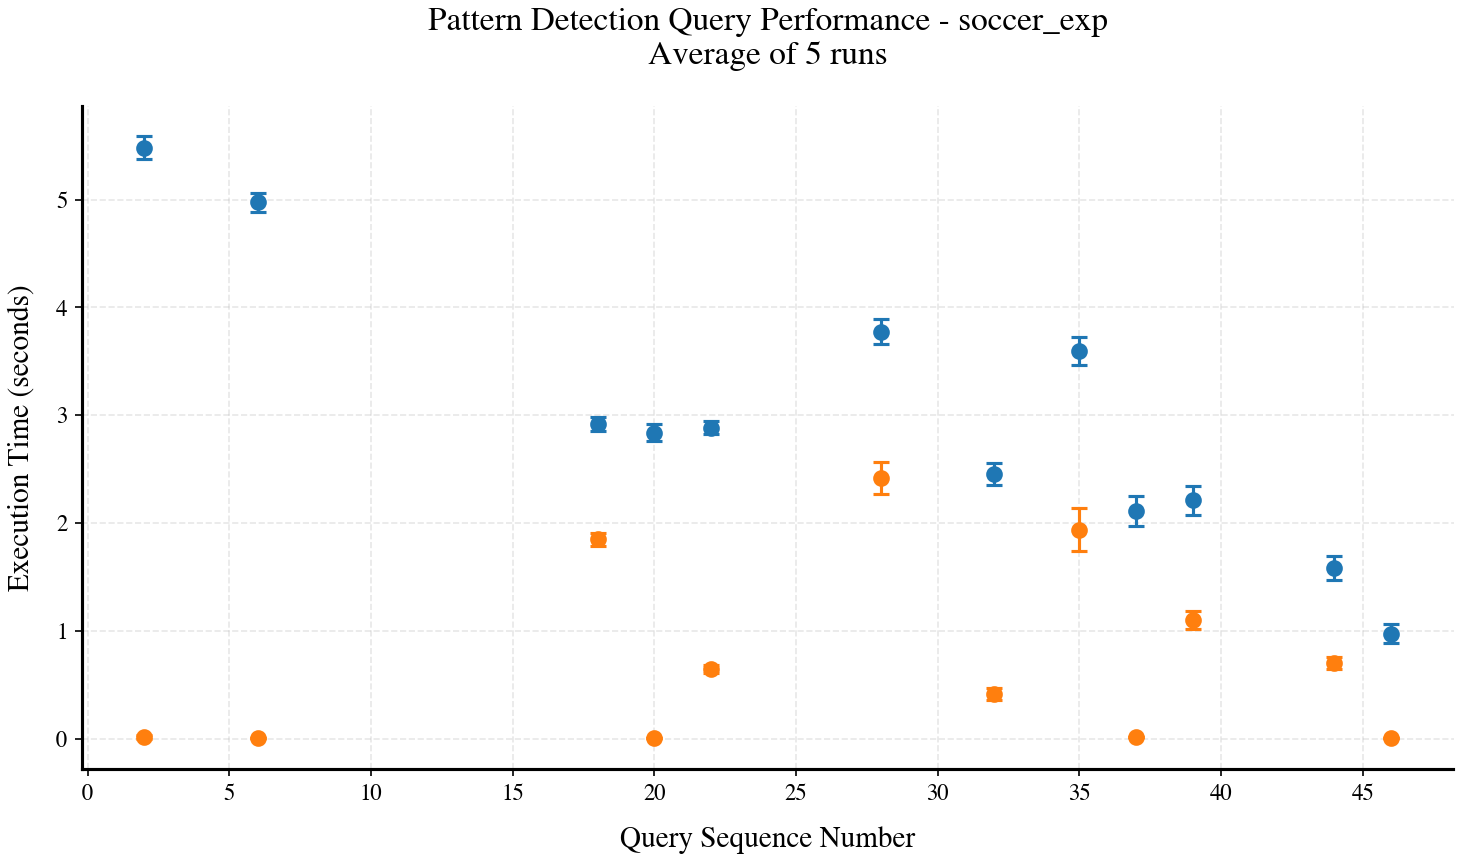

In [9]:
if all_combined is not None:
    # Plot time series for each dataset
    for dataset in all_datasets:
        if dataset in results_by_dataset:
            dataset_df = results_by_dataset[dataset]
            run_count = dataset_df['run_count'].iloc[0]
            
            # Create a publication-ready time series plot
            fig, ax = plt.subplots(figsize=(12, 7))
            
            methods = dataset_df['method'].unique()
            
            # Define markers and line styles by operation type
            markers = {'Pattern Detection': '*', 'Other': 'o'}
            
            # Create a variable to track the max y-value for annotation positioning
            max_y = 0
            
            # Plot each method
            for i, method in enumerate(methods):
                method_data = dataset_df[dataset_df['method'] == method].sort_values('query #')
                
                # Color for this method
                color = METHOD_COLORS[i]
                
                # Plot standard queries with error bars
                line = ax.errorbar(
                    method_data['query #'], 
                    method_data['Time (sec)'],
                    yerr=method_data['Time (sec)_std'],
                    label=method,
                    marker=markers['Other'], 
                    markersize=7, 
                    alpha=0.9,
                    color=color, 
                    linestyle='-', 
                    linewidth=2,
                    capsize=4,
                    capthick=1,
                    elinewidth=1
                )
                
                # Update max y-value for annotations
                max_y = max(max_y, (method_data['Time (sec)']).max())
                                
            # Add highlighting for pattern detection queries
            pattern_queries = dataset_df[dataset_df['operation'] == 'Pattern Detection']['query #'].unique()
            for query_num in pattern_queries:
                ax.axvline(x=query_num, color='lightgray', linestyle='--', alpha=0.5, zorder=0)
            
            # Set proper titles and labels
            title = f'Query Execution Time Evolution - {dataset}'
            subtitle = f'Average of {run_count} runs with standard deviation'
            ax.set_title(f'{title}\n{subtitle}', pad=20)
            ax.set_xlabel('Query Sequence Number')
            ax.set_ylabel('Execution Time (seconds)')
            
            # Format x-axis as integers
            ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
            
            # Apply publication styling
            set_publication_style(ax, legend_title='Query Method')
            
            plt.tight_layout()
            
            # Save figure
            filename_safe = dataset.replace(' ', '_').lower()
            plt.savefig(os.path.join(FIGURES_DIR, f"time_evolution_{filename_safe}.pdf"))
            plt.savefig(os.path.join(FIGURES_DIR, f"time_evolution_{filename_safe}.png"))
            plt.show()
            
            # Create a separate plot showing only pattern detection queries if they exist
            pattern_methods = []
            for method in methods:
                method_data = dataset_df[dataset_df['method'] == method]
                pd_data = method_data[method_data['operation'] == 'Pattern Detection']
                if not pd_data.empty:
                    pattern_methods.append(method)
            
            if pattern_methods:
                fig, ax = plt.subplots(figsize=(10, 6))
                
                for i, method in enumerate(pattern_methods):
                    method_data = dataset_df[dataset_df['method'] == method]
                    pd_data = method_data[method_data['operation'] == 'Pattern Detection'].sort_values('query #')
                    
                    ax.errorbar(
                        pd_data['query #'], 
                        pd_data['Time (sec)'],
                        yerr=pd_data['Time (sec)_std'],
                        label=method, 
                        marker=markers['Other'],
                        markersize=7,
                        color=METHOD_COLORS[i],
                        capsize=4,
                        capthick=1.5,
                        elinewidth=1.5,
                        linewidth=0
                    )
                
                # Set titles and labels
                title = f'Pattern Detection Query Performance - {dataset}'
                subtitle = f'Average of {run_count} runs'
                ax.set_title(f'{title}\n{subtitle}', pad=20)
                ax.set_xlabel('Query Sequence Number')
                ax.set_ylabel('Execution Time (seconds)')
                
                # Format x-axis as integers
                ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
                
                # Apply publication styling
                set_publication_style(ax, legend_title='Query Method')
                
                plt.tight_layout()
                
                # Save figure
                plt.savefig(os.path.join(FIGURES_DIR, f"pattern_detection_{filename_safe}.pdf"))
                plt.savefig(os.path.join(FIGURES_DIR, f"pattern_detection_{filename_safe}.png"))
                plt.show()
else:
    print("No data available for plotting time evolution.")

## Performance Distribution Analysis

Compare the distribution of query times between methods for each dataset using aggregated statistics.

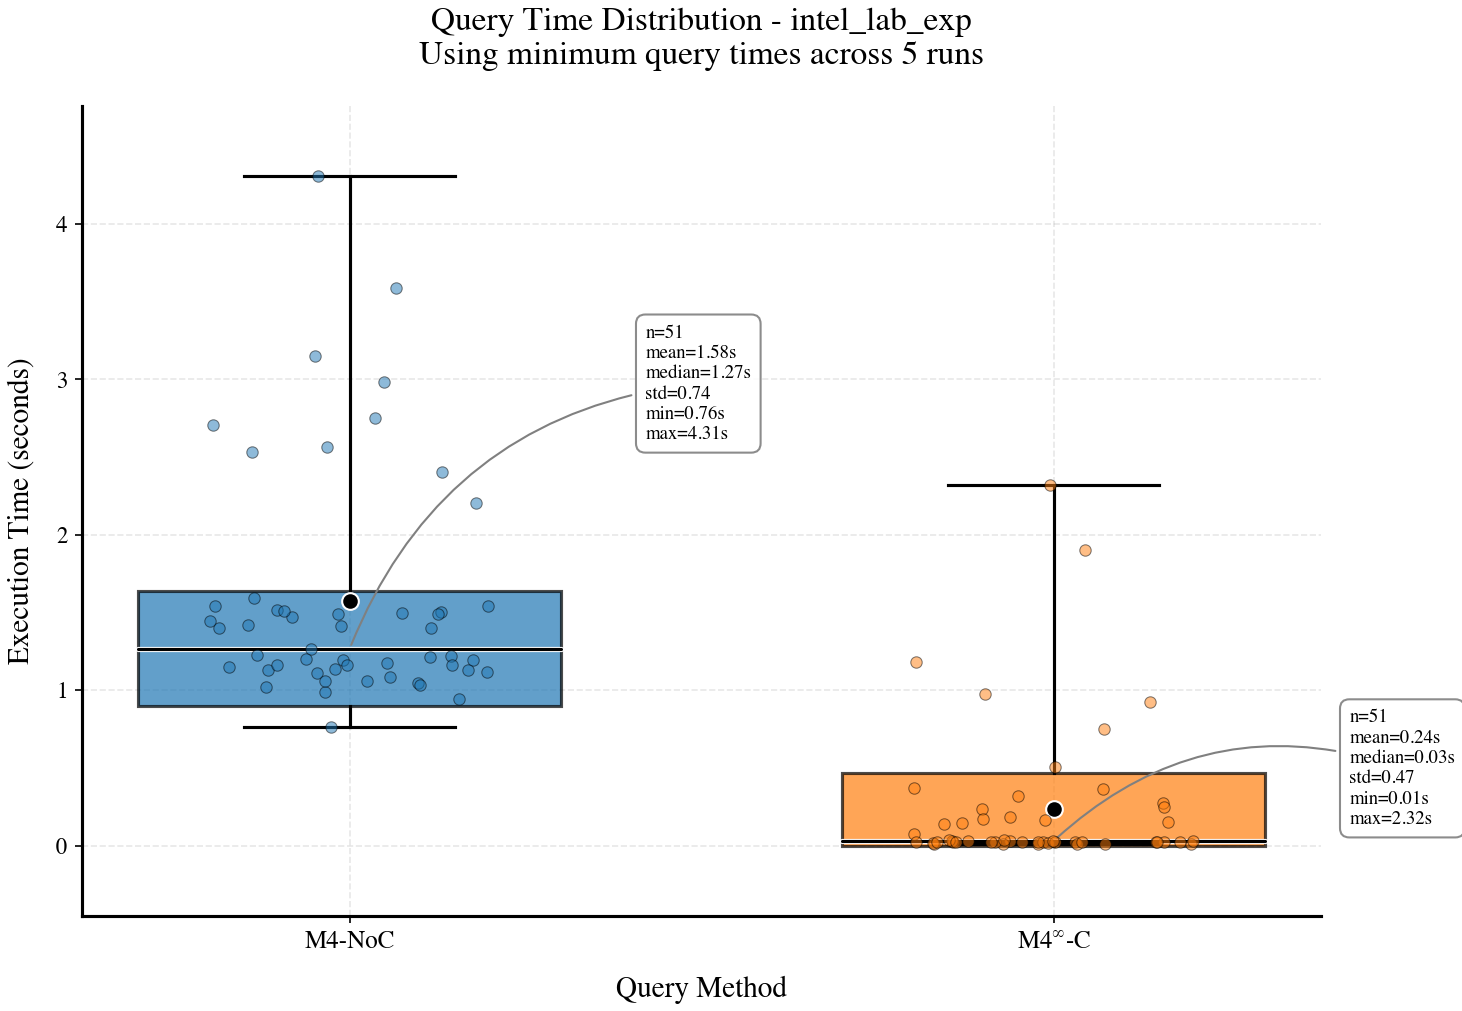

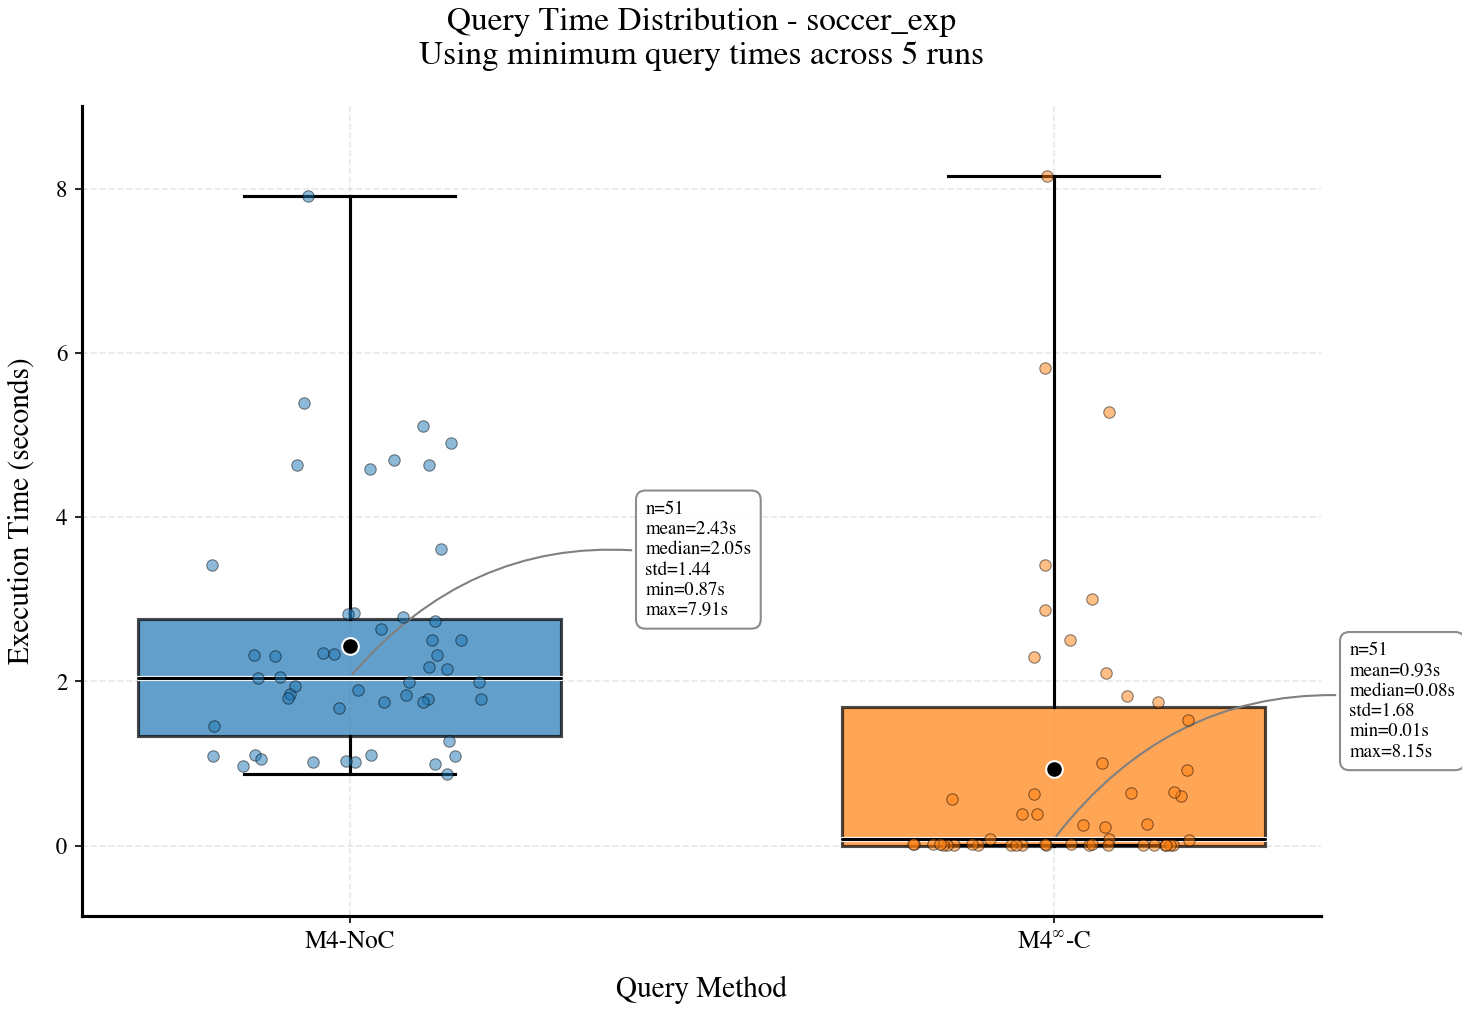

In [46]:
if all_combined is not None:
   
    # We'll use raw_results_by_dataset to get the minimum value for each query
    for dataset in all_datasets:
        if dataset in raw_results_by_dataset:
            dataset_df = raw_results_by_dataset[dataset]
            run_count = len(dataset_df['run'].unique())
            
            # Create publication-ready chart for performance distribution
            fig, ax = plt.subplots(figsize=(10, 7))
            
            methods = dataset_df['method'].unique()
            positions = np.arange(len(methods))
            width = 0.6
            
            # Create a more sophisticated boxplot-like visualization using minimum times
            for i, method in enumerate(methods):
                # Get data for this method
                method_data = dataset_df[dataset_df['method'] == method]
                
                # Calculate the minimum time for each unique query across all runs
                min_times_by_query = method_data.groupby(['query #'])['Time (sec)'].min().reset_index()
                
                # Calculate statistics on these minimum times
                mean_val = min_times_by_query['Time (sec)'].mean()
                median_val = min_times_by_query['Time (sec)'].median()
                min_val = min_times_by_query['Time (sec)'].min()
                max_val = min_times_by_query['Time (sec)'].max()
                std_val = min_times_by_query['Time (sec)'].std()
                
                # Draw box - Ensure box doesn't go below zero
                box_bottom = max(0, median_val - std_val/2)  # Use max() to prevent negative values
                box_height = std_val
                box = plt.Rectangle(
                    (i-width/2, box_bottom),
                    width, box_height,
                    alpha=0.7,
                    facecolor=METHOD_COLORS[i % len(METHOD_COLORS)],
                    edgecolor='black',
                    linewidth=1.5
                )
                ax.add_patch(box)
                
                # Draw median line
                ax.plot([i-width/2, i+width/2], [median_val, median_val], 
                        color='white', linewidth=2.5, solid_capstyle='round')
                ax.plot([i-width/2, i+width/2], [median_val, median_val], 
                        color='black', linewidth=1.5, solid_capstyle='round')
                
                # Draw whiskers (min-max) - Ensure whiskers don't go below zero
                ax.plot([i, i], [max(0, min_val), box_bottom], 
                        color='black', linewidth=1.5, linestyle='-')
                ax.plot([i, i], [box_bottom + box_height, max_val], 
                        color='black', linewidth=1.5, linestyle='-')
                
                # Draw caps on whiskers
                whisker_width = width / 4
                ax.plot([i-whisker_width, i+whisker_width], [max(0, min_val), max(0, min_val)], 
                        color='black', linewidth=1.5)
                ax.plot([i-whisker_width, i+whisker_width], [max_val, max_val], 
                        color='black', linewidth=1.5)
                
                # Draw mean point
                ax.plot(i, mean_val, 'o', color='white', markersize=8)
                ax.plot(i, mean_val, 'o', color='black', markersize=6)
                
                # Add annotation with statistics
                stats_text = (
                    f"n={len(min_times_by_query)}\n"
                    f"mean={mean_val:.2f}s\n"
                    f"median={median_val:.2f}s\n"
                    f"std={std_val:.2f}\n"
                    f"min={min_val:.2f}s\n"
                    f"max={max_val:.2f}s"
                )
                
                # Improved stats text positioning strategy
                text_x = i + width * 0.7  # Position to the right side of the box
                text_y = (box_bottom + box_height + max_val) / 2  # Middle between box top and max whisker
                
                # Alternative positioning based on dataset characteristics
                if max_val > mean_val * 3:  # If we have extreme outliers
                    text_y = median_val + std_val  # Place near the upper part of the box
                
                # Ensure text is always inside the plot area
                y_min, y_max = ax.get_ylim()
                text_y = min(max(text_y, y_min + (y_max - y_min) * 0.15), y_max * 0.85)
                
                # Add connecting line from box to annotation
                ax.annotate(
                    stats_text,
                    xy=(i, median_val),  # Start from the median line
                    xytext=(text_x, text_y),  # End at the text position
                    textcoords="data",
                    ha='left',
                    va='center',
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.9),
                    arrowprops=dict(arrowstyle="-", color="gray", connectionstyle="arc3,rad=0.3")
                )
            
            # Set axis properties
            ax.set_xticks(positions)
            ax.set_xticklabels(methods, fontsize=12)
            
            # Set titles and labels
            title = f'Query Time Distribution - {dataset}'
            subtitle = f'Using minimum query times across {run_count} runs'
            ax.set_title(f'{title}\n{subtitle}', pad=20)
            ax.set_xlabel('Query Method')
            ax.set_ylabel('Execution Time (seconds)')
            
            # Plot actual data points with jitter for better visibility
            for i, method in enumerate(methods):
                # Get data for this method
                method_data = dataset_df[dataset_df['method'] == method]
                
                # Get minimum times for each query across runs
                min_times_by_query = method_data.groupby(['query #'])['Time (sec)'].min().values
                
                # Create jitter for better point separation
                jitter = np.random.uniform(-width/3, width/3, size=len(min_times_by_query))
                
                # Plot individual points with semi-transparency
                ax.scatter(
                    [i + j for j in jitter], 
                    min_times_by_query,
                    s=30,
                    alpha=0.5,
                    color=METHOD_COLORS[i % len(METHOD_COLORS)],
                    edgecolor='black',
                    linewidth=0.5,
                    zorder=3
                )
            
            # Apply publication styling but without legend
            set_publication_style(ax)
            
            # Adjust y-axis range
            y_min, y_max = ax.get_ylim()
            margin = (y_max - y_min) * 0.05
            ax.set_ylim(y_min - margin, y_max + margin)
            
            plt.tight_layout()
            
            # Save figure
            filename_safe = dataset.replace(' ', '_').lower()
            plt.savefig(os.path.join(FIGURES_DIR, f"min_time_distribution_{filename_safe}.pdf"))
            plt.savefig(os.path.join(FIGURES_DIR, f"min_time_distribution_{filename_safe}.png"))
            plt.show()
    
else:
    print("No data available for distribution analysis.")

In [ ]:
import re
from sklearn.metrics import f1_score, precision_score, recall_score

def extract_patterns(filepath):
    # Extract main [start to end] intervals per pattern
    with open(filepath, "r") as f:
        content = f.read()
    pattern = re.compile(r"Match #\d+: \[(\d+) to (\d+)\]")
    return set((int(m.group(1)), int(m.group(2))) for m in pattern.finditer(content))

def compute_f1(gt_file, pred_file):
    gt_patterns = extract_patterns(gt_file)
    pred_patterns = extract_patterns(pred_file)
    # For F1, construct binary indicator vectors over union of all intervals
    all_patterns = sorted(gt_patterns | pred_patterns)
    gt_labels = [1 if p in gt_patterns else 0 for p in all_patterns]
    pred_labels = [1 if p in pred_patterns else 0 for p in all_patterns]
    precision = precision_score(gt_labels, pred_labels)
    recall = recall_score(gt_labels, pred_labels)
    f1 = f1_score(gt_labels, pred_labels)
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    return f1

# Example usage:
ground_truth_file = "ground_truth_1380223372541_2036598918397_1_AggregateInterval{1 Days}.log"
predicted_file = "YOUR_PREDICTIONS_FILE.log" # <-- change to your file
compute_f1(ground_truth_file, predicted_file)